# 训练不具备分离能力的网络
basicamt.py

In [ ]:
import torch
import os
import tqdm

import sys
sys.path.append("..")
from utils.checkpoint import save_ckpt_template as save_ckpt, load_ckpt_template as load_ckpt

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True   # 加速卷积计算
else:
    device = torch.device('cpu')

print(device)

cuda


In [ ]:
from data.data import Instruments
dataset = Instruments(
    folder = '../data/piano_large_short_256',
    mix = 1,
    input = '.cqt.npy',
    output = '.npy'
)
print("训练集大小: ", len(dataset))
input, label = dataset[0]
print("输入大小: ", input.shape)
print("输出大小: ", label.shape)
# 如果开了benchmark，batchsize最好一样大，且是两个数据集大小的公因数
dataloader = torch.utils.data.DataLoader(dataset, batch_size=18, shuffle=True, pin_memory=True, num_workers=4)

val = Instruments(
    folder = '../data/piano_medium_short_256',
    mix = 1,
    input = '.cqt.npy',
    output = '.npy'
)
print("测试集大小: ", len(val))
input, label = val[0]
print("输入大小: ", input.shape)
print("输出大小: ", label.shape)
valloader = torch.utils.data.DataLoader(val, batch_size=18, shuffle=False, pin_memory=True, num_workers=4)

训练集大小:  1800
输入大小:  torch.Size([1, 2, 288, 360])
输出大小:  torch.Size([1, 84, 360])
测试集大小:  180
输入大小:  torch.Size([1, 2, 288, 360])
输出大小:  torch.Size([1, 84, 360])


In [3]:
from basicamt import BasicAMT
model = BasicAMT().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.32, patience=2, threshold=1e-3)
checkpoint_path = "basicamt.pth"
loss_path = "basicamt.loss.txt"
min_loss = float('inf')
epoch_now = 0

In [4]:
# 加载上一轮模型参数
states = load_ckpt(model, optimizer, checkpoint_path)
if states:
    min_loss, avg_loss, epoch_now = states
else:
    print("No checkpoint loaded. Training from scratch.")

Checkpoint file 'basicamt.pth' does not exist.
No checkpoint loaded. Training from scratch.


In [5]:
epoch_total = 50
stage_save_interval = 45    # save checkpoint every $stage_save_interval$ epochs

optimizer.zero_grad()
for epoch in range(epoch_now+1, epoch_total):
    # training
    model.train()
    train_loss = 0
    virtual_batch = 0
    for (input, target) in tqdm.tqdm(dataloader):
        input = input.to(device)    # input: (batch, mix, 2, time)
        target = target.to(device)  # target: (batch, mix, 7 * 12, 660)

        # 由于basicamt的目标没有分离音色，因此mix仅仅是数据增强的手段
        if dataset.mix > 1:
            mixed = torch.mean(input, dim=1, keepdim=False)  # 混合后的CQT
            midi_mixed, _ = target.max(dim=-3, keepdim=False)
        else:
            mixed = input.squeeze(dim=1)
            midi_mixed = target.squeeze(dim=1)

        mixed = mixed + torch.randn_like(mixed) * 0.01   # 加入噪声 经过听觉和可视化觉得0.01是一个合适的值
        # midi_mixed: (batch, 7 * 12, 660)

        onset, note = model(mixed)
        # onset & note: (batch, 7 * 12, 660)
        loss = BasicAMT.loss(onset, note, midi_mixed)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= len(dataloader)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (input, target) in tqdm.tqdm(valloader):
            input = input.to(device)
            target = target.to(device)

            if val.mix > 1:
                mixed = torch.sum(input, dim=1, keepdim=False)
                midi_mixed, _ = target.max(dim=-3, keepdim=False)
            else:
                mixed = input.squeeze(dim=1)
                midi_mixed = target.squeeze(dim=1)

            onset, note = model(mixed)
            loss = BasicAMT.loss(onset, note, midi_mixed)
            val_loss += loss.item()

        val_loss /= len(valloader)
    
    final_loss = val_loss * 0.85 + train_loss * 0.15
    schedular.step(final_loss)

    # save checkpoint
    checkpoint_filename = f"epoch{epoch}.pth" if epoch % stage_save_interval == 0 else checkpoint_path
    save_ckpt(epoch, model, min_loss, final_loss, optimizer, checkpoint_filename)
    if final_loss < min_loss:
        min_loss = final_loss

    print(f"====> Epoch: {epoch} Average train loss: {train_loss:.4f}; Average val loss: {val_loss:.4f}")
    with open(loss_path, 'a') as f:
        f.write(f"{epoch}:\ttrain_loss: {train_loss:.4f}\tval_loss: {val_loss:.4f}\n")
    epoch_now = epoch

100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


====> Epoch: 1 Average train loss: 37571.8209; Average val loss: 5898.5370


100%|██████████| 10/10 [00:02<00:00,  4.34it/s]


====> Epoch: 2 Average train loss: 4275.9703; Average val loss: 3374.9979


100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


====> Epoch: 3 Average train loss: 2883.2170; Average val loss: 2540.7081


100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


====> Epoch: 4 Average train loss: 2328.1655; Average val loss: 2127.5387


100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


====> Epoch: 5 Average train loss: 2024.2914; Average val loss: 1889.4146


100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


====> Epoch: 6 Average train loss: 1822.0892; Average val loss: 1723.7312


100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


====> Epoch: 7 Average train loss: 1676.3225; Average val loss: 1626.2163


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


====> Epoch: 8 Average train loss: 1571.2009; Average val loss: 1538.8824


100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


====> Epoch: 9 Average train loss: 1476.0964; Average val loss: 1448.7311


100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


====> Epoch: 10 Average train loss: 1395.8326; Average val loss: 1387.8444


100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


====> Epoch: 11 Average train loss: 1333.5904; Average val loss: 1342.7423


100%|██████████| 10/10 [00:02<00:00,  4.14it/s]


====> Epoch: 12 Average train loss: 1291.0379; Average val loss: 1309.9380


100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


====> Epoch: 13 Average train loss: 1247.9798; Average val loss: 1325.6986


100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


====> Epoch: 14 Average train loss: 1199.8923; Average val loss: 1247.8419


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


====> Epoch: 15 Average train loss: 1164.9352; Average val loss: 1218.2464


100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


====> Epoch: 16 Average train loss: 1130.6551; Average val loss: 1157.0084


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


====> Epoch: 17 Average train loss: 1097.9628; Average val loss: 1243.8314


100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


====> Epoch: 18 Average train loss: 1069.4863; Average val loss: 1338.4027


100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


====> Epoch: 19 Average train loss: 1042.8633; Average val loss: 1118.9887


100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


====> Epoch: 20 Average train loss: 1027.9052; Average val loss: 1063.7016


100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


====> Epoch: 21 Average train loss: 997.9468; Average val loss: 1053.4994


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


====> Epoch: 22 Average train loss: 978.3630; Average val loss: 1038.8322


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


====> Epoch: 23 Average train loss: 964.9308; Average val loss: 1056.5837


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


====> Epoch: 24 Average train loss: 942.5306; Average val loss: 1031.2365


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


====> Epoch: 25 Average train loss: 929.7964; Average val loss: 1004.5200


100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


====> Epoch: 26 Average train loss: 906.4448; Average val loss: 979.2188


100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


====> Epoch: 27 Average train loss: 898.9311; Average val loss: 1017.5055


100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


====> Epoch: 28 Average train loss: 879.1635; Average val loss: 964.2109


100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


====> Epoch: 29 Average train loss: 867.3573; Average val loss: 1030.8999


100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


====> Epoch: 30 Average train loss: 857.2740; Average val loss: 959.5443


100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


====> Epoch: 31 Average train loss: 849.1095; Average val loss: 913.8979


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


====> Epoch: 32 Average train loss: 832.2212; Average val loss: 893.4100


100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


====> Epoch: 33 Average train loss: 830.9625; Average val loss: 915.7458


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


====> Epoch: 34 Average train loss: 812.7899; Average val loss: 955.8427


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


====> Epoch: 35 Average train loss: 805.5127; Average val loss: 1006.1032


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


====> Epoch: 36 Average train loss: 771.4409; Average val loss: 889.3900


100%|██████████| 10/10 [00:02<00:00,  4.17it/s]


====> Epoch: 37 Average train loss: 766.8863; Average val loss: 861.9324


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


====> Epoch: 38 Average train loss: 763.9378; Average val loss: 865.0185


100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


====> Epoch: 39 Average train loss: 757.2081; Average val loss: 871.6290


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


====> Epoch: 40 Average train loss: 758.7033; Average val loss: 853.5244


100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


====> Epoch: 41 Average train loss: 752.8899; Average val loss: 847.7808


100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


====> Epoch: 42 Average train loss: 752.7815; Average val loss: 839.3998


100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


====> Epoch: 43 Average train loss: 748.0009; Average val loss: 864.4179


100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


====> Epoch: 44 Average train loss: 742.1776; Average val loss: 832.7989


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


====> Epoch: 45 Average train loss: 740.5789; Average val loss: 864.3498


100%|██████████| 10/10 [00:02<00:00,  4.17it/s]


====> Epoch: 46 Average train loss: 737.8423; Average val loss: 810.5857


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


====> Epoch: 47 Average train loss: 733.3157; Average val loss: 827.6967


100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


====> Epoch: 48 Average train loss: 730.7680; Average val loss: 867.6626


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

====> Epoch: 49 Average train loss: 727.9900; Average val loss: 844.8492


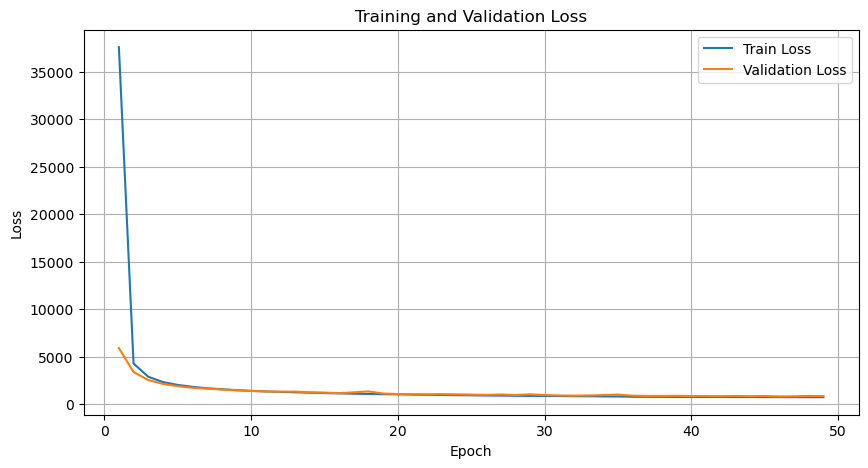

In [6]:
# 绘制训练和验证损失曲线
import matplotlib.pyplot as plt

epochs = []
train_losses = []
val_losses = []

with open(loss_path, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        epoch = int(parts[0].split(':')[0])
        train_loss = float(parts[1].split(': ')[1])
        val_loss = float(parts[2].split(': ')[1])
        
        epochs.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 用半精度加速 会出现nan 不要用
from torch.amp import GradScaler, autocast
scaler = GradScaler()	# 实例化对象

epoch_total = 100
stage_save_interval = 10    # save checkpoint every $stage_save_interval$ epochs
virtual_batch_size = 1      # 梯度累积 缓解显存瓶颈

optimizer.zero_grad()
for epoch in range(epoch_now+1, epoch_total):
    # training
    model.train()
    train_loss = 0
    virtual_batch = 0
    for (input, target) in tqdm.tqdm(dataloader):
        input = input.to(device)
        # input: (batch, mix, 2, 8 * 36, 660)
        target = target.to(device)
        # target: (batch, mix, 7 * 12, 660)

        # 由于basicamt的目标没有分离音色，因此mix仅仅是数据增强的手段
        # 混合CQT并加噪
        mixed = torch.sum(input, dim=1, keepdim=False)  # 混合后的CQT
        mixed = mixed + torch.randn_like(mixed) * 0.008   # 加入噪声
        # 混合midi
        midi_mixed, _ = target.max(dim=-3, keepdim=False)
        # midi_mixed: (batch, 7 * 12, 660)

        with autocast(device_type='cuda'):
            onset, note = model(mixed)
            if torch.isnan(onset).any() or torch.isnan(note).any():
                print("Model output is NaN. Skipping this batch.")
                optimizer.zero_grad()
                continue
            # onset: (batch, 7 * 12, 660)
            # note: (batch, 7 * 12, 660)
            loss = BasicAMT.loss(onset, note, midi_mixed)
            if torch.isnan(loss):
                print("Loss is NaN. Skipping this batch.")
                optimizer.zero_grad()
                continue
            train_loss += loss.item()
            # 梯度累积
            loss = loss / virtual_batch_size

        # loss.backward()
        scaler.scale(loss).backward()
        virtual_batch = (virtual_batch + 1) % virtual_batch_size
        if virtual_batch == 0:
            # optimizer.step()
            scaler.step(optimizer)	# 调整lr
            scaler.update()		# 更新梯度
            optimizer.zero_grad()
    
    if virtual_batch != 0:
        # optimizer.step()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    train_loss /= len(dataloader)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (input, target) in tqdm.tqdm(valloader):
            input = input.to(device)
            target = target.to(device)

            mixed = torch.sum(input, dim=1, keepdim=False)
            midi_mixed, _ = target.max(dim=-3, keepdim=False)

            onset, note = model(mixed)
            loss = BasicAMT.loss(onset, note, midi_mixed)

            val_loss += loss.item()

        val_loss /= len(valloader)
        schedular.step(val_loss)

    # save checkpoint
    checkpoint_filename = f"epoch{epoch}.pth" if epoch % stage_save_interval == 0 else checkpoint_path
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'min_loss': min_loss,
        'avg_loss': val_loss,
        'optimizer': optimizer.state_dict(),
    }, val_loss < min_loss, filename = checkpoint_filename)

    if val_loss < min_loss:
        min_loss = val_loss

    print(f"====> Epoch: {epoch} Average train loss: {train_loss:.4f}; Average val loss: {val_loss:.4f}")
    with open(loss_path, 'a') as f:
        f.write(f"{epoch}:\ttrain_loss: {train_loss:.4f}\tval_loss: {val_loss:.4f}\n")
    epoch_now = epoch


## 测试模型

In [7]:
# 加载最佳模型
states = load_ckpt(model, optimizer, "best_" + checkpoint_path)
if states:
    min_loss, avg_loss, epoch_now = states
else:
    print("No best checkpoint loaded.")

Checkpoint loaded from 'best_basicamt.pth'
epoch: 46, loss: 799.6741782531737, min_loss: 819.2056848602294


In [8]:
# 切换到cpu 因为benchmark会导致初次运行时间长
device = torch.device('cpu')
model = model.to(device)
torch.backends.cudnn.benchmark = False

In [ ]:
# CQT配置
import tomllib
with open('../model/config.toml', 'br') as f:
    CQTconfig = tomllib.load(f)['CQT']
s_per_frame = CQTconfig['hop'] / CQTconfig['fs']

from model.CQT import CQTsmall

cqt = CQTsmall(
    CQTconfig['fs'],
    fmin=CQTconfig['fmin'],
    octaves=CQTconfig['octaves'],
    bins_per_octave=CQTconfig['bins_per_octave'],
    hop=CQTconfig['hop'],
    filter_scale=CQTconfig['filter_scale'],
    requires_grad=False
)


In [ ]:
# 读取音频，分析为CQT
import torchaudio
from utils.midiarray import numpy2midi
from utils.wavtool import waveInfo
import matplotlib.pyplot as plt
import numpy as np

test_wave_path = "../data/inferMusic/piano_short.wav"
# test_wave_path = r'C:\amt\data\septimbre\small\inst0\0.wav'
waveInfo(test_wave_path)

waveform, sample_rate = torchaudio.load(test_wave_path, normalize=True)
waveform = waveform.unsqueeze(0)
print(waveform.shape)
test_cqt_data = cqt(waveform).to(device)
print(test_cqt_data.shape)

Sample rate: 44100
Channels: 2
Sample width: 2
Number of frames: 186112
Duration (s): 4.220226757369614
data num: 372224
torch.Size([1, 2, 186112])
torch.Size([1, 2, 288, 727])


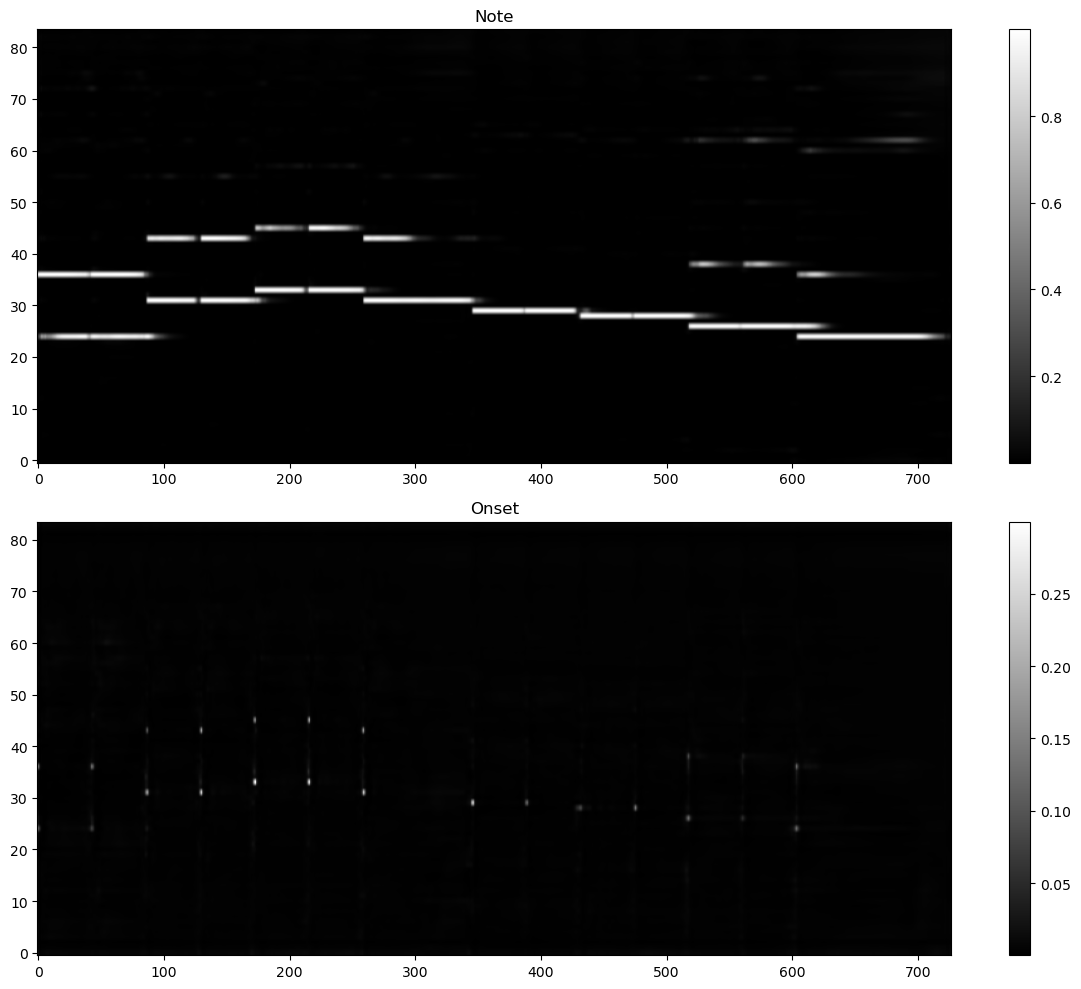

In [11]:
model.eval()
with torch.no_grad():
    onset, note = model(test_cqt_data)
    onset = onset.cpu().numpy()[0]
    note = note.cpu().numpy()[0]
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    plt.title('Note')
    plt.imshow(note, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.subplot(2, 1, 2)
    plt.title('Onset')
    plt.imshow(onset, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    
    